In [151]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# HW4: Model Metrics and Calibration

In this assignment, we will be looking at metrics used to evaluate models similar to what we saw in class. However, we will add an additional wrinkle to see how these metrics are impacted. For the following tasks, do not use the implementation found in `sklearn`. You can find a reference on the topics covered in this homework from the lecture notes [here](https://github.com/dsahduke/model_assessment_calibration) as well as [this wikipedia article](https://en.wikipedia.org/wiki/Confusion_matrix)

### Read in dataset

In [152]:
output_df = pd.read_csv("./data/example_output.csv")

> The dataset in `output_df` represents predictions made at each hour within a patient encounter of developing an infection. For this dataset, we consider the 8 hours right before the infection occurs as a positive label (1) and every other hour as a negative label (0). If a patient does not have an infection, then all of their labels will be negative (0).

## Task 1: Confusion Matrix [10 pts]

Write a function that takes in a dataframe with at least 2 columns: label and prediction, and returns the confusion matrix for a given threshold. You can choose to represent the confusion matrix however you choose (as a list of lists, or numpy arrays), but be sure to include the number of True Positives, False Positives, True Negatives, and False Negatives.

In [153]:
def confusion_matrix(risk_df, label_column_name, prediction_column_name, threshold):
    """Computes a confusion matrix given a dataframe of labels and predictions
    
    Parameters
    ----------
    risk_df : pd.DataFrame
        Dataframe containing `label_column_name` and `prediction_column_name`
    label_column_name : str
        Name of the column in `risk_df` which contains the label (0 or 1)
    prediction_column_name : str
        Name of the column in `risk_df` which contains the risk score
    
    Returns
    -------
    <FILL IN DEPENDING ON IMPLEMENTATION>
    """
    label = risk_df[label_column_name]
    prediction = risk_df[prediction_column_name]
    
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(label)):
        if(label[i] == 1 and prediction[i] >= threshold):
            TP = TP + 1
        elif (label[i] == 0 and prediction[i] >= threshold):
            FP = FP + 1
        elif (label[i] == 0 and prediction[i] < threshold):
            TN = TN + 1
        else:
            FN = FN + 1
    confusion_matrix = np.zeros([2,2])
    confusion_matrix[0,0] = TN
    confusion_matrix[1,0] = FN
    confusion_matrix[0,1] = FP
    confusion_matrix[1,1] = TP

    return confusion_matrix

Apply this function to the `output_df` with a threshold of 0.2, 0.4, and 0.6

In [154]:
confusion_matrix(output_df, 'label', 'prediction', 0.2)

array([[13284., 20154.],
       [  334.,  3162.]])

In [155]:
confusion_matrix(output_df, 'label', 'prediction', 0.4)

array([[25620.,  7818.],
       [ 1538.,  1958.]])

In [156]:
confusion_matrix(output_df, 'label', 'prediction', 0.6)

array([[31416.,  2022.],
       [ 2763.,   733.]])

## Task 2: Receiver Operating Characteristic [15 pts]

As we mentioned in class, the Receiver Operating Characteristic looks at the sensitivity and specificity of a given classifier over all possible thresholds. Write a function that takes in the dataframe of predictions and labels and returns a grid of sensitivities and (1 - specificity) to graph an ROC curve. Graph the ROC curve for `output_df` and add a line to show the theoretically random classifier. 

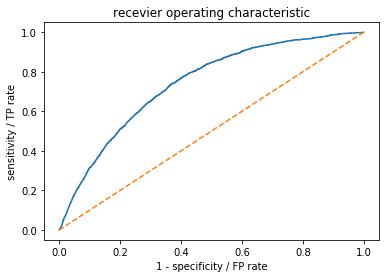

In [195]:
from sklearn import metrics
spec, sens, thresholds = metrics.roc_curve(output_df['label'].values, output_df['prediction'].values)
plt.plot(spec1, sens1)
plt.plot([1, 0],[1, 0], linestyle = '--')
plt.title('recevier operating characteristic')
plt.xlabel('1 - specificity / FP rate')
plt.ylabel('sensitivity / TP rate')
plt.show()

## Task 3: Precision Recall Curve [15 pts]

For inbalanced classes, the Receiver Operating Characteristic can be a misleading measure of binary classification performance. Instead, it can be useful to look at points on the Precision-Recall curve. For the `output_df`, plot the precision recall curve by writing your own implementation. 

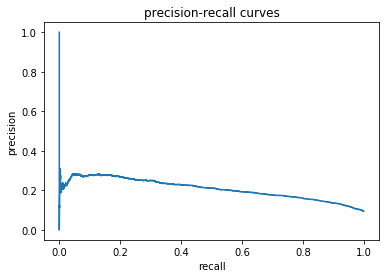

In [196]:
prec, rec, thresholds = metrics.precision_recall_curve(output_df['label'].values, output_df['prediction'].values)
plt.plot(rec, prec)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision-recall curves')
plt.show()

## Task 4: Unit of observation [45 pts]

For the two above tasks, you looked at the Receiver Operating Characteristic as well as the Precision Recall curve. However, one important thing to note is that each pair of prediction and label is actually 1 hour of a patient encounter. What does each of these scenarios represent (in your own words?). We have filled in true positive for you as a starting point. 

#### True positive

A true positive in this case represents a predicted score above a certain threshold within 8 hours of an infection occurring. 

#### False Positive 

#### True Negative 

#### False Negative 

We said that precision-recall might be a good metric to use in this setting where the classes are imbalanced. However, looking at each hour individually may not give us the best idea of how well this model works *at the encounter level*. Instead, write code to generate a precision-recall curve using the following definitions:

 * Recall: Proportion of encounters which have at least 1 risk score above a threshold within 8 hours of an infection (label = 1)
 * Precision: Proportion of risk scores which are above a threshold that are within 8 hours of an infection 

Note that this means that we are defining the recall based on the *encounter*, but the precision based on each *hour*.

### Hints

 * Determine how many total encounters there are where there is a label that is positive. This means that the encounter had an infection in its course. This number will stay constant, so there is no need to compute it in a loop
 * Iterate through the possible thresholds (i.e. risk scores) and determine the True Positive Rate (at the encounter level) and the proportion of predictions above the threshold for time points where the label is equal to 1.
 * If you want to speed up computation, you can round the risk scores to 3 digits

In [197]:
def get_precision_recall_encounter(output_df, 
                                   label_column_name,
                                   prediction_column_name,
                                   encounter_id_column_name):
    """Get a precision and recall based on the encounter level
      
    Parameters
    ----------
    risk_df : pd.DataFrame
        Dataframe containing `label_column_name` and `prediction_column_name`
    label_column_name : str
        Name of the column in `risk_df` which contains the label (0 or 1)
    prediction_column_name : str
        Name of the column in `risk_df` which contains the risk score
    encounter_id_column_name: str
        Name of the column in `risk_df` which contains the encounter_id
    
    Returns
    -------
    precision, recall, threshold : Tuple(List, List, List)
    """
    label = np.asarray(output_df[label_column_name])
    risk_score  = np.asarray(output_df[prediction_column_name])
    encounter_id = np.asarray(output_df[encounter_id_column_name])
    
    encounter_pos = encounter_id[np.where(label==1)]
    encounter_pos = np.unique(encounter_pos)
    total_pos = len(encounter_pos)
    tps = np.zeros(risk_score.shape)
    tps_en = np.zeros(risk_score.shape)

    uniq_encounter = []
    for i in range(1,len(risk_score)):
        if(label[i] == 1):
            tps[i]=tps[i-1]+1
            if(encounter_id[i] not in uniq_encounter):
                uniq_encounter.append(encounter_id[i])
                tps_en[i] = tps_en[i-1]+1
            else:
                tps_en[i] = tps_en[i-1]      
        else:
            tps[i]=tps[i-1]
            tps_en[i] = tps_en[i-1]          
    precision = tps/list(range(len(risk_score)))
    precision[np.isnan(precision)] = 1
    recall = tps_en/total_pos
    threshold = risk_score
    
    return precision, recall, threshold

C:\Users\Jiaxu\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


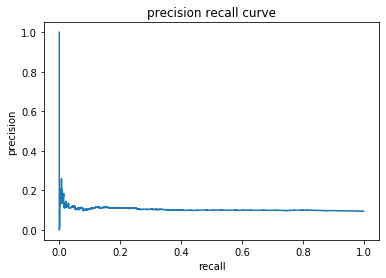

In [198]:
precision, recall, threshold = get_precision_recall_encounter(output_df,'label','prediction','encounter_id')
plt.figure()
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

## Task 5: Calibration Plot [15 pts]

Now, go back to assuming that each hour is the unit of interest, and plot the calibration curve. The x-axis represents the predicted probabilities for each decile. You can plot the points using the middle of each decile (0.05, 0.15, etc.). The y-axis should contain the empirical proportion of positive examples for that predicted probabilities in that decile. For example, if for all examples that have a predicted probabilitiy between 0 and .1 there are 20/100 positive examples, the coordinate would be (0.05, 0.2). Plot a line for a theoretically calibrated model.

Is this model calibrated? If not, does the model systematically overestimate risk or underestimate it?

In [205]:
def calibration_plot(output_df, label_column_name, prediction_column_name):
    label = np.asarray(output_df[label_column_name])
    risk_score  = np.asarray(output_df[prediction_column_name])
    example_x = np.round(np.arange(0.0, 1.0, 0.1),1)
    example_y = np.zeros(example_x.shape)
    
    for i in range(len(example_x)):
        x = example_x[i]
        index_x = np.where((risk_score>= x) & (risk_score < x+0.1))
        total = len(index_x[0])
        pos = np.sum(label[index_x])
        example_y[i] = pos/total
    
    example_x = example_x + 0.05
    return example_x, example_y

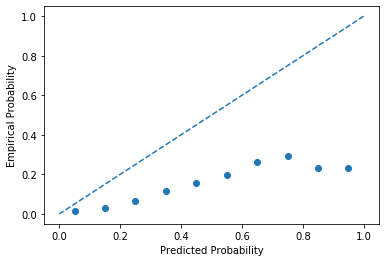

In [206]:
example_x, example_y = calibration_plot(output_df,'label','prediction')
plt.scatter(example_x, example_y)
plt.plot([1, 0], [1, 0], linestyle = '--')
plt.xlabel('Predicted Probability')
plt.ylabel('Empirical Probability')
plt.show()

In [ ]:
# No. Underestimate.